In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, mean_squared_error
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import time
import torch.utils.data as torch_data

## 1. Reconstruction of MNIST with MLP-based autoencoder

In [14]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)

#Get only first 1000 pictures for test
x_test=x_test[:1000]
y_test=y_test[:1000]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=50,
                                         shuffle=False, num_workers=2)

[mnist] x_train.shape=(60000, 784), y_train.shape=(60000,)
[mnist] x_test.shape=(1000, 784), y_test.shape=(1000,)


### 1.1 MLP-1

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))


In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                       

                        torch.nn.Linear(1024, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    start = time.time()
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X  in train_loader:
            # Perform one step of minibatch stochastic gradient descent 
          
          X=X.to(device)
        
          out=net(X)
          loss=criterion(out,X)

          optimizer.zero_grad()

          loss.backward()
          optimizer.step()
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
    
        net.eval()
        for X in val_loader:
            # Compute the validation loss
             
            X=X.to(device)
            out=net(X)
            val_loss=criterion(out,X)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))
    end= time.time()
    print("construction completed in "+str(end-start)+'s')


In [19]:
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6366.8628 | Validation 5772.5972
Epoch 100/1000 || Loss:  Train 5539.7612 | Validation 5061.0610
Epoch 150/1000 || Loss:  Train 4852.4736 | Validation 4397.3823
Epoch 200/1000 || Loss:  Train 4214.6733 | Validation 3817.4009
Epoch 250/1000 || Loss:  Train 3508.3542 | Validation 3263.2881
Epoch 300/1000 || Loss:  Train 3000.0315 | Validation 2767.7749
Epoch 350/1000 || Loss:  Train 2512.1885 | Validation 2339.1348
Epoch 400/1000 || Loss:  Train 2124.1599 | Validation 1935.3882
Epoch 450/1000 || Loss:  Train 1737.1848 | Validation 1595.3475
Epoch 500/1000 || Loss:  Train 1377.3967 | Validation 1303.2766
Epoch 550/1000 || Loss:  Train 1210.3452 | Validation 1035.6305
Epoch 600/1000 || Loss:  Train 962.2159 | Validation 804.5050
Epoch 650/1000 || Loss:  Train 777.8326 | Validation 633.1445
Epoch 700/1000 || Loss:  Train 662.7560 | Validation 486.7805
Epoch 750/1000 || Loss:  Train 513.0101 | Validation 362.0652
Epoch 800/1000 || Loss:  Train 444.9934 | Validat

decode one sample in 0.0010091104507446288s


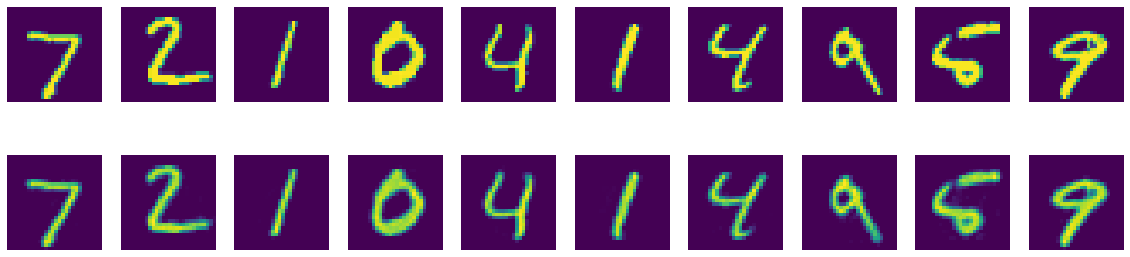

In [22]:

net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
for X in test_loader:
    start=time.time()
    X=X.to(device)
    reconstructions_batch=net(X)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
rec = rec.cpu().detach().numpy()

mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')

fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

test_loader = torch.utils.data.DataLoader(x_test, batch_size=50,
                                         shuffle=False, num_workers=2)

for X_test in test_loader:
  for i in range(10):
      im = X_test[i,:].numpy()
      ax[0, i].imshow(im.reshape(28,28));
      ax[1, i].imshow(rec[i].reshape(28,28))
      ax[0, i].axis('off')
      ax[1, i].axis('off')
  break

### 1.2 MLP-2

In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(784,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                       

                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                       

                        torch.nn.Linear(2048, 784, bias=True),
                        torch.nn.BatchNorm1d(784),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


In [0]:
epochs = 1000
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

Epoch 50/1000 || Loss:  Train 6374.8267 | Validation 5731.6572
Epoch 100/1000 || Loss:  Train 5317.6318 | Validation 4981.0796


In [0]:

net.eval()
test_loader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)
batch_count=0
reconstruction_time=[]
for X in test_loader:
    start=time.time()
    X=X.to(device)
    reconstructions_batch=net(X)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec = reconstructions_batch
    else:
      rec = torch.cat((rec, reconstructions_batch), dim=0)
    batch_count += 1
rec = rec.cpu().detach().numpy()

mean=np.mean(np.array(reconstruction_time))
print("decode one sample in "+str(mean)+'s')


fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
test_loader = torch.utils.data.DataLoader(x_test, batch_size=50,
                                         shuffle=False, num_workers=2)

for X_test in test_loader:
  for i in range(10):
      im = X_test[i,:].numpy()
      ax[0, i].imshow(im.reshape(28,28));
      ax[1, i].imshow(rec[i].reshape(28,28))
      ax[0, i].axis('off')
      ax[1, i].axis('off')
  break